## Mounting Google Drive
This allows us to use our data kept in google drive and also save our models.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip './gdrive/MyDrive/Colab Notebooks/prepared_data_aptos_binary.zip'

Archive:  ./gdrive/MyDrive/Colab Notebooks/prepared_data_atpos_binary.zip
   creating: prepared_data_atpos_binary/test_data/
   creating: prepared_data_atpos_binary/test_data/0 - no_dr/
  inflating: prepared_data_atpos_binary/test_data/0 - no_dr/e4dcca36ceb4.png  
  inflating: prepared_data_atpos_binary/test_data/0 - no_dr/e50b0174690d.png  
  inflating: prepared_data_atpos_binary/test_data/0 - no_dr/e5197d77ec68.png  
  inflating: prepared_data_atpos_binary/test_data/0 - no_dr/e529c5757d64.png  
  inflating: prepared_data_atpos_binary/test_data/0 - no_dr/e582e56e7942.png  
  inflating: prepared_data_atpos_binary/test_data/0 - no_dr/e594c19e2e1d.png  
  inflating: prepared_data_atpos_binary/test_data/0 - no_dr/e59c5f345bb0.png  
  inflating: prepared_data_atpos_binary/test_data/0 - no_dr/e5de79795c1d.png  
  inflating: prepared_data_atpos_binary/test_data/0 - no_dr/e5f332efcbc7.png  
  inflating: prepared_data_atpos_binary/test_data/0 - no_dr/e5f73f2855c0.png  
  inflating: prepared_da

## Importing our data
We use the ImageDataGenerator of Tensorflow to make the training, validation and testing sets

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
datagen=ImageDataGenerator( rescale=1./255 )
train_data=datagen.flow_from_directory('./prepared_data_aptos_binary/train_data/', target_size=(224, 224), batch_size=8, class_mode='categorical', shuffle=True)
val_data=datagen.flow_from_directory('./prepared_data_aptos_binary/val_data/', target_size=(224, 224), batch_size=8, class_mode='categorical', shuffle=True)
test_data=datagen.flow_from_directory('./prepared_data_aptos_binary/test_data/', target_size=(224, 224), batch_size=8, class_mode='categorical', shuffle=True)

Found 2930 images belonging to 2 classes.
Found 366 images belonging to 2 classes.
Found 366 images belonging to 2 classes.


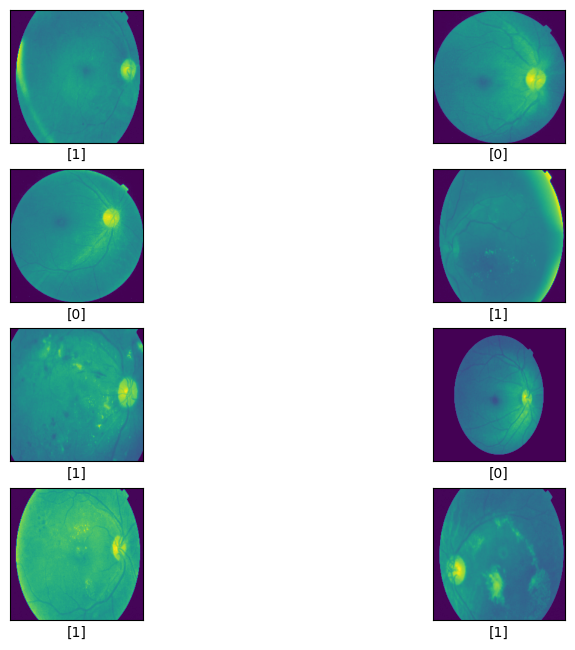

In [ ]:
# visualizing our data
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for ((images, labels), i) in zip(train_data, range(1)):
      for ((image, label), i) in zip(zip(images, labels), range(10)):
        plt.subplot(5,2,i+1)
        i+=1
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image.mean(axis=2))
        plt.xlabel(label.nonzero()[0])
plt.show()

## Making our Model
We make use of the VGG16 model in making our model. Because the imagenet weights were not trained on images related to our use case, we train the last few layers in addition to the fully connected layers

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, LSTM, Dropout, BatchNormalization

In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
base_model = VGG16(weights = 'imagenet', input_shape =(224,224,3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
for layer in base_model.layers:
  layer.trainable = False
for layer in base_model.layers[-8:]:
  layer.trainable = True
head_model = base_model.get_layer('fc2').output
head_model = Dense(2, activation='softmax')(head_model)
model = Model(inputs = base_model.input, outputs = head_model)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint('./gdrive/MyDrive/Colab Notebooks/models/diabetic_retinopathy_binary_checkpoint.keras', monitor = 'val_accuracy', save_best_only = True)
earlystop = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)
learning_rate = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3)
callbacks = [checkpoint, earlystop, learning_rate]

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer = Adam(learning_rate = 1e-5), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.fit(train_data,
          validation_data = val_data,
          epochs = 45,
          callbacks = callbacks)

Epoch 1/45
367/367 [==============================] - 51s 132ms/step - loss: 0.2631 - accuracy: 0.9055 - val_loss: 0.1267 - val_accuracy: 0.9563 - lr: 1.0000e-05
Epoch 2/45
367/367 [==============================] - 34s 91ms/step - loss: 0.1677 - accuracy: 0.9444 - val_loss: 0.1204 - val_accuracy: 0.9563 - lr: 1.0000e-05
Epoch 3/45
367/367 [==============================] - 53s 143ms/step - loss: 0.1515 - accuracy: 0.9512 - val_loss: 0.0944 - val_accuracy: 0.9699 - lr: 1.0000e-05
Epoch 4/45
367/367 [==============================] - 35s 96ms/step - loss: 0.1139 - accuracy: 0.9611 - val_loss: 0.0844 - val_accuracy: 0.9563 - lr: 1.0000e-05
Epoch 5/45
367/367 [==============================] - 35s 95ms/step - loss: 0.1053 - accuracy: 0.9655 - val_loss: 0.1521 - val_accuracy: 0.9563 - lr: 1.0000e-05
Epoch 6/45
367/367 [==============================] - 35s 95ms/step - loss: 0.0861 - accuracy: 0.9717 - val_loss: 0.0942 - val_accuracy: 0.9645 - lr: 1.0000e-05
Epoch 7/45
367/367 [============

In [ ]:
model.save('./gdrive/MyDrive/Colab Notebooks/models/diabetic_retinopathy_binary.keras')

## Testing
Now that the model has been trained. We evaluate our training, testing, and validation sets. We also calculate the accuracy and show the confusion matrix and classification report.

In [ ]:
# run if testing after having already created the model
# run the mounting code at the start
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator( rescale=1./255 )
train_data=datagen.flow_from_directory('./prepared_data_aptos_binary/train_data/', target_size=(224, 224), batch_size=8, class_mode='categorical', shuffle=True)
val_data=datagen.flow_from_directory('./prepared_data_aptos_binary/val_data/', target_size=(224, 224), batch_size=8, class_mode='categorical', shuffle=True)
test_data=datagen.flow_from_directory('./prepared_data_aptos_binary/test_data/', target_size=(224, 224), batch_size=8, class_mode='categorical', shuffle=True)

model = load_model('./gdrive/MyDrive/Colab Notebooks/models/diabetic_retinopathy_binary.keras')

In [ ]:
loss_train, acc_train = model.evaluate(train_data)
print(acc_train)
print(loss_train)

367/367 [==============================] - 19s 52ms/step - loss: 0.0318 - accuracy: 0.9928
0.9928327798843384
0.03176965191960335


In [ ]:
loss_val, acc_val = model.evaluate(val_data)
print(acc_val)
print(loss_val)

46/46 [==============================] - 3s 55ms/step - loss: 0.0818 - accuracy: 0.9754
0.9754098653793335
0.08184947073459625


In [ ]:
loss_test, acc_test = model.evaluate(test_data)
print(acc_test)
print(loss_test)

46/46 [==============================] - 2s 49ms/step - loss: 0.1316 - accuracy: 0.9645
0.9644808769226074
0.13158036768436432


In [ ]:
import os
from PIL import Image
y_p = []
y_t = []
for dirpath, dirname, filenames in os.walk('./prepared_data_aptos_binary/test_data/0 - no_dr/'):
  for filename in filenames:
    im = Image.open('./prepared_data_aptos_binary/test_data/0 - no_dr/'+filename).resize((224, 224), Image.ANTIALIAS)
    im = np.array(im)
    im = im.astype(float)
    im /= 255
    prediction = model.predict(im[None,:,:,:])
    y_t.append(0)
    y_p.append(np.argmax(prediction))
for dirpath, dirname, filenames in os.walk('./prepared_data_aptos_binary/test_data/1 - dr/'):
  for filename in filenames:
    im = Image.open('./prepared_data_aptos_binary/test_data/1 - dr/'+filename).resize((224, 224), Image.ANTIALIAS)
    im = np.array(im)
    im = im.astype(float)
    im /= 255
    prediction = model.predict(im[None,:,:,:])
    y_t.append(1)
    y_p.append(np.argmax(prediction))
y_t = np.array(y_t)
y_p = np.array(y_p)

<ipython-input-85-a1ec635c6a39>:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = Image.open('./prepared_data_atpos_binary/test_data/0 - no_dr/'+filename).resize((224, 224), Image.ANTIALIAS)


1/1 [==============================] - 0s 17ms/step


<ipython-input-85-a1ec635c6a39>:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = Image.open('./prepared_data_atpos_binary/test_data/1 - dr/'+filename).resize((224, 224), Image.ANTIALIAS)


1/1 [==============================] - 0s 16ms/step


In [ ]:
pd.Series(y_p).value_counts()

0    221
1    145
Name: count, dtype: int64

In [ ]:
pd.Series(y_t).value_counts()

0    199
1    167
Name: count, dtype: int64

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print(accuracy_score(y_t, y_p))
print(confusion_matrix(y_t, y_p))
print(classification_report(y_t, y_p))

0.9016393442622951
[[192   7]
 [ 29 138]]
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       199
           1       0.95      0.83      0.88       167

    accuracy                           0.90       366
   macro avg       0.91      0.90      0.90       366
weighted avg       0.91      0.90      0.90       366

